<h1 style="text-align: center; color: purple;" markdown="1"> How did the banning of assault weapons in Maryland affect gun violence?  </h1>

<h2 style="text-align: center; color: #012169" markdown="1"> A difference in difference analysis </h2>

<h3 style="text-align: center; color: #012169" markdown="1"> Scott Masterson </h3>

### Table of Contents 
* [Introduction](#anchor1)
* [The Data Set](#anchor2)
* [Methodology/Empirical Model](#anchor5)
* [Conclusion](#anchor9)
* [Sources](#anchor10)

## Introduction <a class = anchor id = anchor1></a>

#### Background on the Law
In 2013, a law passed in Maryland that "required a license to buy any form of handgun and banned any future sales of specifically named “assault weapons” as well as firearms with certain cosmetic features" (tacticalgear.com). The law, known as the Firearm Safety Act, faced opposition for years and wasn't able to be fully into effect until 2016. When the law was reconsidered years after it was initially proposed, the full court ruled that ssault weapons and magazines holding more than 10 rounds are not protected by the Second Amendment; the law was in full effect partway through 2016. 

### Research question: How did the tightening of the Firearms Safety Act in 2016 affect gun violenece?

The research question is important to consider since gun laws tend to be on the more controversial side of politics. Some people see gun laws as restrictions of freedom and unalienable rights, whereas others see it as a necessary protection against gun violence.

## The Datasets <a class = anchor id = anchor2></a>

Three datasets have been drawn from and merged together to benefit the analysis:
* Gun Violence (kaggle)
* Police Information (FBI)
* Census Data (US Census Bureau)

(see [Sources](#anchor10) for access to these datasets)

In [200]:
### Packages

# foundational
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# for regression
import statsmodels.formula.api as smf
import scipy.stats as stats
from IPython.core.display import HTML
from scipy.stats import t
from stargazer.stargazer import Stargazer

# SQL to group by and count
from pandasql import sqldf
mysql = lambda q: sqldf(q, globals())

# file path from computer
import os
path = os.getcwd()
print(path) 
print(type(path))

# remove data warnings 
import warnings
warnings.filterwarnings("ignore")

/Users/scottmasterson/Documents/Junior_Year/Econ_371
<class 'str'>


#### Importing, cleaning, and manipulating the gun violence data

In [201]:
df_dirty = pd.read_csv("/Users/scottmasterson/Documents/Junior_Year/Econ_371/gun-violence-data_01-2013_03-2018.csv")
df_dirty.head(1)

used_vars = ['state', 'n_killed', 'n_injured', 'date']
df_dirty2 = df_dirty[used_vars]

df_dirty2['datetime'] = pd.to_datetime(df_dirty2['date'], format = '%Y-%m-%d')
df_dirty2['year'] = df_dirty2['datetime'].dt.year
df_clean = df_dirty2.drop(['datetime', 'date'], axis = 1)

length_total = len(df_dirty2)
count = 0
for i in range(df_clean.shape[1]): #check if NA's will be a problem
    count += df_dirty2[used_vars[i]].isna().sum()

print("The dataset has " + str(length_total) + " total observations. There are " + str(count) + " NA's among the variables of interest")
df_clean.head()


The dataset has 239677 total observations. There are 0 NA's among the variables of interest


,state,n_killed,n_injured,year
0,Pennsylvania,0,4,2013
1,California,1,3,2013
2,Ohio,1,3,2013
3,Colorado,4,0,2013
4,North Carolina,2,2,2013


There was a data collection issue in 2013 and 2018, so not all incidents of gun violence were captured during those years. In order to improve estimates, the year 2013 and 2018 will be dropped from the data set.

In [202]:
df_clean = df_clean[(df_clean['year'] > 2013) & (df_clean['year'] < 2018)]
print(df_clean['year'].head(2))
print(df_clean['year'].tail(2))

278    2014
279    2014
Name: year, dtype: int64
225873    2017
225874    2017
Name: year, dtype: int64


In [222]:
# this cell must run twice to work

df_clean['treatment'] = df_clean['state']
df_clean['post'] = df_clean['year']

df_clean.loc[(df_clean.treatment == 'New Jersey') ,'treatment'] = 0
df_clean.loc[(df_clean.treatment == 'Maryland') ,'treatment'] = 1
df_clean.loc[(df_clean.post <= 2016) ,'post'] = 0
df_clean.loc[(df_clean.post > 2016), 'post'] = 1

df = df_clean[(df_clean['state'] == 'Maryland') | (df_clean['state'] == 'New Jersey')]

df_clean['treatment*post'] = df_clean['treatment']*df_clean['post']

df = df[['state', 'year', 'n_killed', 'n_injured', 'treatment', 'post', 'treatment*post']]
df

,state,year,n_killed,n_injured,treatment,post,treatment*post
279,New Jersey,2014,0,0,0,0,0
291,Maryland,2014,0,0,1,0,0
297,New Jersey,2014,0,1,0,0,0
317,New Jersey,2014,0,0,0,0,0
333,Maryland,2014,1,0,1,0,0
...,...,...,...,...,...,...,...
225804,Maryland,2017,0,0,1,1,1
225814,New Jersey,2017,1,0,0,1,0
225821,New Jersey,2017,1,0,0,1,0
225837,New Jersey,2017,4,0,0,1,0


Below, the final manipulations are made to get the dataset in a working form for difference and difference analysis.

In [228]:
gun_violence_data = mysql('''SELECT state, year, sum(n_killed) AS n_killed, sum(n_injured) AS n_injured, treatment, post, treatment*post 
                    FROM df
                    GROUP BY year, state
                    ORDER by state''')

gun_violence_data


,state,year,n_killed,n_injured,treatment,post,treatment*post
0,Maryland,2014,294,602,1,0,0
1,Maryland,2015,404,783,1,0,0
2,Maryland,2016,429,748,1,0,0
3,Maryland,2017,480,855,1,1,1
4,New Jersey,2014,278,628,0,0,0
5,New Jersey,2015,249,491,0,0,0
6,New Jersey,2016,297,654,0,0,0
7,New Jersey,2017,275,663,0,1,0


Now that this dataset is cleaned, other variables must be added from other datasets to strengthen the analysis.

#### Importing, cleaning, and manipulating the Census Data

In [230]:
extra_vars_dirty = pd.read_csv("/Users/scottmasterson/Documents/Junior_Year/Econ_371/unemp_rpcinc_poverty_1995_2020.csv")

extra_vars_dirty2 = extra_vars_dirty[(extra_vars_dirty['year'] > 2013) & 
                                     (extra_vars_dirty['year'] < 2018) &
                                     ((extra_vars_dirty['stfips'] == 24) | # code for Maryland
                                     (extra_vars_dirty['stfips'] == 34)) ] # code for New Jersey

extra_vars_dirty2 = extra_vars_dirty2.rename(columns={"stfips": "state"})

extra_vars_dirty2.loc[(extra_vars_dirty2.state == 24) , 'state'] = 'Maryland'
extra_vars_dirty2.loc[(extra_vars_dirty2.state == 34) , 'state'] = 'New Jersey'

extra_vars_clean = extra_vars_dirty2.drop(['rpcinc'], axis = 1)
extra_vars_clean

,state,year,pop,pctpoverty,unemp
539,Maryland,2014,5976407,10.4,5.8
540,Maryland,2015,6006401,9.9,5.1
541,Maryland,2016,6016447,9.7,4.5
542,Maryland,2017,6052177,9.4,4.3
799,New Jersey,2014,8938175,11.1,6.6
800,New Jersey,2015,8958013,10.8,5.8
801,New Jersey,2016,8944469,10.4,5.0
802,New Jersey,2017,9005644,10.0,4.6


#### Importing, cleaning, and manipulating the Census Data
Using FBI police data for the years 2014, 2015, 2017. Unfortunately, 2016 was not available.

In [232]:
more_vars_dirty = pd.read_excel('/Users/scottmasterson/Documents/Junior_Year/Econ_371/Table_77_Full_time_Law_Enforcement_Employess_by_State_2014-2018.xls', 
                   usecols = 'A:I', skiprows = 5).drop(['Total officers: Male', 'Total officers: Female', 'Total civilians: Male', 'Total civilians: Female'], axis = 1)


more_vars_dirty2 = more_vars_dirty.rename(columns={"Total law enforcement employees":'total law enforcement employees'})


more_vars_dirty2['police_percap'] = more_vars_dirty2['total law enforcement employees']/more_vars_dirty2['estimated population']*100

more_vars_dirty2.loc[(more_vars_dirty2.state == 'NEW JERSEY  ') , 'state'] = 'New Jersey'
more_vars_dirty2.loc[(more_vars_dirty2.state == 'MARYLAND  ') , 'state'] = 'Maryland'

more_vars_dirty3 = more_vars_dirty2[(more_vars_dirty2['state'] == 'Maryland') | 
                                    (more_vars_dirty2['state'] == 'New Jersey')] 

more_vars_clean = more_vars_dirty3[['state', 'year', 
                                    'total law enforcement employees', 'police_percap',
                                    'number of agencies', 'estimated population']].sort_values(['state'])

more_vars_clean


,state,year,total law enforcement employees,police_percap,number of agencies,estimated population
20,Maryland,2014,20745,0.347182,152,5975249.0
70,Maryland,2015,22959,0.382315,154,6005259.0
121,Maryland,2017,20060,0.331506,150,6051172.0
172,Maryland,2018,19916,0.329648,149,6041598.0
30,New Jersey,2014,38778,0.448646,536,8643347.0
80,New Jersey,2015,39376,0.453985,538,8673407.0
131,New Jersey,2017,40469,0.464733,534,8708009.0
182,New Jersey,2018,40847,0.472847,531,8638529.0


Time to put all of the datasets together.

In [233]:
new_df = pd.merge(gun_violence_data, extra_vars_clean,  how='left', on = ['year', 'state'])
df_complete = pd.merge(new_df, more_vars_clean,  how='left', on = ['year', 'state'])

df_complete

,state,year,n_killed,n_injured,treatment,post,treatment*post,pop,pctpoverty,unemp,total law enforcement employees,police_percap,number of agencies,estimated population
0,Maryland,2014,294,602,1,0,0,5976407,10.4,5.8,20745.0,0.347182,152.0,5975249.0
1,Maryland,2015,404,783,1,0,0,6006401,9.9,5.1,22959.0,0.382315,154.0,6005259.0
2,Maryland,2016,429,748,1,0,0,6016447,9.7,4.5,NaN,NaN,NaN,NaN
3,Maryland,2017,480,855,1,1,1,6052177,9.4,4.3,20060.0,0.331506,150.0,6051172.0
4,New Jersey,2014,278,628,0,0,0,8938175,11.1,6.6,38778.0,0.448646,536.0,8643347.0
5,New Jersey,2015,249,491,0,0,0,8958013,10.8,5.8,39376.0,0.453985,538.0,8673407.0
6,New Jersey,2016,297,654,0,0,0,8944469,10.4,5.0,NaN,NaN,NaN,NaN
7,New Jersey,2017,275,663,0,1,0,9005644,10.0,4.6,40469.0,0.464733,534.0,8708009.0


* The main dependent variable being examined is n_killed
* The main independent variables being examined are pctpoverty, police_percap, n_injured, and unemp

New Jersey has been chosen as the control group since a similar law was passed in 2013, but not ammendments, additions, or alterations were made to that law in 2016. Furthermore, New Jersey and Maryland have similar demographic composition, political leaning, and wealth distribution (objectivelists.com).

## Model <a class = anchor id = anchor3></a>

Regression modelling will be used for the analysis. 

$$ n killed = \beta_0 + \beta_1*treatment + \beta_2*post + \beta_3*treatment*post + \beta_4*n injured + \beta_5*unemp + \beta_6*police percap + \beta_7*pctpoverty + u $$

#### Endogeneity and Exogeneity Concerns
While endogeneity may be of some concern, most of the variables being examined will not possess an enodgenous relationship. The only potential endogeneity issue could be with the police_percap variable since the number of people killed may influence funding for a larger police force and a larger police force may discourage the number of people being killed. 

Exogeneity is not an issue since laws are exogenous in nature.

#### Biases and other Limitations
Sampling bias or other forms of data collection bias are not a problem since the data being used are all census-based. The main limitation of modelling with this data is the small amount of data available for the different years. The analysis would be stronger if data from 2008 to 2020 was available, for example.  

The model itself may produce bias due to the endogeneity problem discussed, but the main problem that may be encountered lies in the fact that the number of observations (years where the data exists) is so small.

It's also important to consider the correlations between each of the variables themselves. The correlation matrix below helps visualize how the variables may relate to one another:

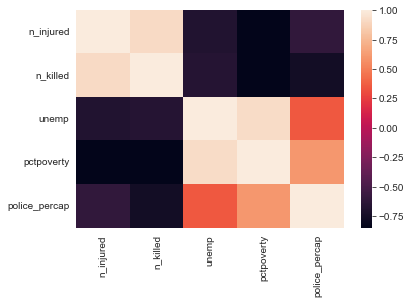

In [218]:
corrMatrix = df_complete[['n_injured', 'n_killed', 'unemp', 'pctpoverty', 'police_percap']].corr()
sns.heatmap(corrMatrix);

The correlation matrix shows that the only variable correlated with the dependent variable (n_killed) is n_injured. The rest of the variables are negatively correlated with the dependent variable. The lack of correlation may weaken our estimation techniques.

In order to adjust for this lack of correlation, a regression will be run with all variables and a regression will be run with only the variables correlated with the dependent variable.

## Results <a class = anchor id = anchor4></a>
The results section will provide an analysis of the data through descriptive statistcs, brief visualizations, and by running a linear regression.

#### Descriptive Statistics 
The descriptive statistics are grouped by state and year for comparison.

In [223]:
df_complete.groupby(['state', 'year']).agg(['mean'])[['n_killed', 'n_injured', 'unemp', 'police_percap', 'pctpoverty', 'pop']]


n_killed n_injured unemp police_percap pctpoverty      pop
                    mean      mean  mean          mean       mean     mean
state      year                                                           
Maryland   2014      294       602   5.8      0.347182       10.4  5976407
           2015      404       783   5.1      0.382315        9.9  6006401
           2016      429       748   4.5           NaN        9.7  6016447
           2017      480       855   4.3      0.331506        9.4  6052177
New Jersey 2014      278       628   6.6      0.448646       11.1  8938175
           2015      249       491   5.8      0.453985       10.8  8958013
           2016      297       654   5.0           NaN       10.4  8944469
           2017      275       663   4.6      0.464733       10.0  9005644

Maryland's gun violence seems to be more prevalent than New Jersey's, despite New Jersey having a larger population.

#### Regression Modelling 
The data is broken down into two groups for use in the regression analysis.

In [ ]:
maryland = df_complete[df_complete['state'] == 'Maryland']
new_jersey = df_complete[df_complete['state'] == 'New Jersey']

In [224]:
model1 = smf.ols(formula =
                'n_killed ~ treatment + post + treatment*post + n_injured + unemp + police_percap + pctpoverty', 
                data=maryland).fit()

model2 = smf.ols(formula =
                'n_killed ~ treatment + post + treatment*post + n_injured + unemp + police_percap + pctpoverty', 
                data=new_jersey).fit()

model3 = smf.ols(formula =
                'n_killed ~ treatment + post + treatment*post + n_injured + unemp + police_percap + pctpoverty', 
                data= df_complete).fit()


model4 = smf.ols(formula =
                'n_killed ~ treatment + post + treatment*post + n_injured', 
                data= df_complete).fit()


In [227]:
st = Stargazer([model1, model2, model3, model4])
st.title("Regression Outputs for Number of People Killed Due to Gun Violence")
st.add_custom_notes(["(1) corresponds to Maryland", 
                     '(2) corresponds to New Jersey', 
                     '(3) the complete dataset',
                     '(4) the complete dataset with variables that correlate with the dependent variable'])
HTML(st.render_html())

Unfortunately, the data itself does not have enough observations to produce unbiased estimates and the issue with correlation presents challenges when running the regression. Ideally, the number of observations would be greater than 30 and the independent variables woiuld be correlated with the dependent variable. Therefore, we cannot draw significant conclusions from the regression models (1), (2), and (3) as many entries have been computed to "inf" or "nan."

Regarding regression (4), the n_injured variable is found to be positively correlated with the independent variable "n_injured" with a p value less than 0.1; however, the regression itself does not provide strong evidence for the efficacy of the gun law. 

#### Data Visualizations
The law in Maryland came into effect in 2016. These quick visualizations help examine how the n_killed and n_injured variables change over time within each state.

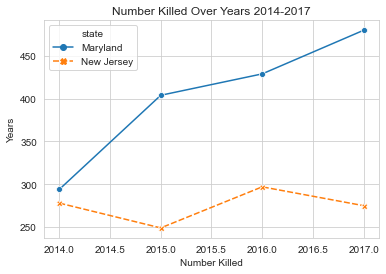

In [207]:
sns.set_style("whitegrid")
p1 = sns.lineplot(data = df_complete, 
                  y = 'n_killed' , 
                  x = "year", 
                  hue = 'state', 
                  style = 'state', 
                  markers = True).set(xlabel = 'Number Killed', ylabel = 'Years', title='Number Killed Over Years 2014-2017');


The number of deaths from gun violence after 2016 increases for Maryland, but decreases for New Jersey.

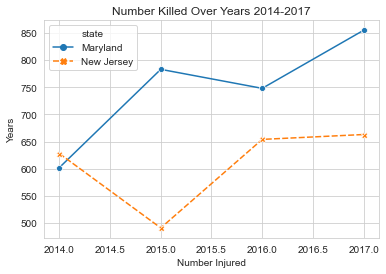

In [219]:
p2 = sns.lineplot(data = df_complete, 
                  y = 'n_injured' , 
                  x = "year", 
                  hue = 'state', 
                  style = 'state', 
                  markers = True).set(xlabel = 'Number Injured', ylabel = 'Years', title='Number Killed Over Years 2014-2017');

The number of injuries from gun violence after 2016 increases for Maryland, but decreases for New Jersey.

## Conclusion <a class = anchor id = anchor5></a>

#### The Results Section Analysis
According to the descriptive statistics section, Maryland had experienced wider-spread gun violence than New Jersey from 2014 to 2017 despite having a smaller population and lower rates of unemployment for all 4 years. Furthermore, Maryland did have a lower police percapita than New Jersey, so that may have something to do with the higher amounts of gun violence, but this can't be statistically proven from this investigation. 

The regressions run in order to piece together difference in difference estimation, were inconclusive for providing accurate estimation for the dependent variable. As discussed previously, the data itself posed problems for the model: many of the variables were uncorrelated with the dependent variable.

The strongest evidence for examining how gun violence changed over time was from the visualization section. Clearly, Maryland's gun violence problem was left unsolved after the passing of the law in 2016, when Maryland's n_injured and n_killed variables continued to increase. When compared to the control group in this DiD estimation, New Jersey's gun violence trends remained relatively static. 

In consideration of evidence presented, no causal inference can be drawn and it is difficult to offer any recommendations for public policy from just this investigation alone. According to an external source, one recommendation would be to construct a law that focuses on limiting handgun usage, since most gun violence related homocides are committed through the use of a handgun (ABCnews.com). The fact presented the external source may hint at why the investigation wasn't able to draw significant results since the law focused on assault weapons which are a more uncommon weapon of choice. 

#### Strengths 
* New Jersey was a great choice for a control group due to similarities with Maryland and the fact that New Jersey didn't pass any gun laws from 2014-2017
* Data was sourced from reputible locations
* Data was census-based 

#### Limitations
* Observation number was too small
* Needed a greater year range
* Most of the independent variables were uncorrelated with the dependent variable

#### Takeaways
It would be expected that a gun law banning assault weapons and limiting the purchase of modifications for weaponry would decrease the number of those killed and injured by gun violence after the passing of the law; however, according to the descriptive statistics and data visualizations the opposite is found. While statistical significance was not obtained and the regression modelling wasn't parametrically robust, the comparison between New Jersey and Maryland offers a brief insight: gun violence tended to be increasing in Maryland, while gun violence in New Jersey tended to remain constant over the years 2014 to 2017.

## Sources <a class = anchor id = anchor10></a>

Dataset by Kaggle: https://www.kaggle.com/datasets/jameslko/gun-violence-data

FBI Police Dataset: https://ucr.fbi.gov/crime-in-the-u.s

Gun Law Background: https://tacticalgear.com/experts/maryland-assault-weapons-ban

Finding A Control Group: https://objectivelists.com/2022/11/13/which-states-are-most-similar-to-maryland/

ABC News Article: https://abcnews.go.com/US/type-gun-us-homicides-ar-15/story?id=78689504

&nbsp;

<hr />

<p style="text-align: center;">Econ 371: Health Economics </a></p>
<p style="text-align: center;"> <em> Scott Masterson</em></a></p>

<p style="text-align: center;">Emory University</a></p>
<p style="text-align: center;"> Fall 2022</a></p>

&nbsp;


In [234]:
!jupyter nbconvert --to html Econ_371_Project_Masterson.ipynb

[NbConvertApp] Converting notebook Econ_371_Project_Masterson.ipynb to html
[NbConvertApp] Writing 718093 bytes to Econ_371_Project_Masterson.html
